<a href="https://colab.research.google.com/github/Akshitwadhwa/Stock-modelling/blob/main/Time_series_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is the third colab notebook made for selecting the stocks using MPT and making optimal portfolios based upon them

###1.1 This is the notebook which cotains the time series of portfolio returns.We have taken the same nifty 50 stocks for this


### **1.2 What is Time Series**
Time series analysis involves the study of the collected data point which were recorded over time.
In financial terms is is also know as the historical price and the performace data of the financial assests.

**One of the important feature of time series is trend analysis which helps in identifying long term movements or the patterns in the data**
**Another thing the trend series helps us understand is the performance metrics**


In [ ]:
## Firstly we are going to import the neccesary libraries which are
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import cvxpy as cp
import random

## 2. Time seires and it realtion with MPT

-- Time series plays a crucial role in making an optimal portfolio as the data given by the time series is crucial in calculating the optimal returns as well as the expected returns for each asset.

-- Time series analysis allows investors to compute correlation coefficients between different assets.

-- Time series models (ARIMA, LSTM, etc.) are used to forecast returns or volatility.

In [ ]:
# Step 1: Collect Data
nifty50_stocks = [
    "RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "ICICIBANK.NS", "KOTAKBANK.NS",
    "HINDUNILVR.NS", "SBIN.NS", "LT.NS", "ITC.NS", "AXISBANK.NS", "BAJFINANCE.NS",
    "ASIANPAINT.NS", "MARUTI.NS", "SUNPHARMA.NS", "ULTRACEMCO.NS", "NESTLEIND.NS", "WIPRO.NS",
    "NTPC.NS", "POWERGRID.NS", "COALINDIA.NS", "TITAN.NS", "TECHM.NS", "GRASIM.NS",
    "BHARTIARTL.NS", "HCLTECH.NS", "DRREDDY.NS", "ADANIENT.NS", "BAJAJFINSV.NS", "TATASTEEL.NS",
    "HDFCLIFE.NS", "SBILIFE.NS", "HEROMOTOCO.NS", "DIVISLAB.NS", "INDUSINDBK.NS", "JSWSTEEL.NS",
    "CIPLA.NS", "EICHERMOT.NS", "UPL.NS", "BPCL.NS", "BRITANNIA.NS", "SHREECEM.NS",
    "ONGC.NS", "APOLLOHOSP.NS", "BAJAJ-AUTO.NS", "M&M.NS", "HINDALCO.NS", "TATACONSUM.NS",
    "TATAMOTORS.NS", "SBICARD.NS"
]

In [ ]:
price_data = yf.download(nifty50_stocks, start="2024-01-01", end="2024-02-01")

[*********************100%***********************]  50 of 50 completed


### 2. This time we have taken random stocks rather than applying some metrics upon it.

### firstly we are going to plot the historical graph and returns using time series

In [ ]:
# we have already downloaded the data above and loaded all the 50 stocks in it
price_data.head(12)

Price             Close                                           \
Ticker      ADANIENT.NS APOLLOHOSP.NS ASIANPAINT.NS  AXISBANK.NS   
Date                                                               
2024-01-01  2916.023926   5727.949219   3357.800537  1096.853394   
2024-01-02  2931.217773   5724.263672   3353.104004  1092.406982   
2024-01-03  3001.789551   5746.128906   3335.554199  1097.752808   
2024-01-04  2997.091309   5740.052734   3341.832520  1122.533691   
2024-01-05  3005.388184   5732.133301   3317.707764  1136.073120   
2024-01-08  2962.305420   5660.160645   3261.202148  1121.134766   
2024-01-09  3013.385010   5775.366699   3230.650635  1115.688965   
2024-01-10  3096.950928   5778.604004   3249.782471  1106.146362   
2024-01-11  3079.657959   5847.338379   3251.117188  1124.881836   
2024-01-12  3102.848877   5773.423828   3240.834473  1119.485962   
2024-01-15  3088.254639   5873.736816   3236.978271  1118.636719   
2024-01-16  3055.267822   5881.854980   3259.718994  1118.236938   

Price                                                               \
Ticker     BAJAJ-AUTO.NS BAJAJFINSV.NS BAJFINANCE.NS BHARTIARTL.NS   
Date                                                                 
2024-01-01   6647.077148   1675.343018   7262.590820   1007.435730   
2024-01-02   6611.317871   1685.136841   7392.936523   1016.037842   
2024-01-03   6930.176270   1676.592285   7347.912598   1029.463013   
2024-01-04   6866.345215   1700.876831   7667.060059   1042.092651   
2024-01-05   6922.240723   1708.422119   7672.632324   1040.799805   
2024-01-08   6927.547852   1695.280396   7697.358398   1043.236328   
2024-01-09   7036.710449   1681.389160   7686.861328   1058.600586   
2024-01-10   6996.884277   1670.795898   7642.185059   1056.810547   
2024-01-11   7240.008301   1668.197510   7631.439453   1056.959717   
2024-01-12   7243.083496   1650.858521   7622.782715   1070.384888   
2024-01-15   7243.083496   1631.370850   7440.646973   1096.290649   
2024-01-16   7235.147949   1622.476440   7419.403809   1089.826660   

Price                                ...       Volume                \
Ticker         BPCL.NS BRITANNIA.NS  ... SUNPHARMA.NS TATACONSUM.NS   
Date                                 ...                              
2024-01-01  214.766174  5251.446289  ...       733452        936544   
2024-01-02  216.761581  5220.894531  ...      3174447       2635193   
2024-01-03  219.042023  5186.294434  ...      1699057       1100701   
2024-01-04  215.051224  5292.413086  ...      2851729       2777186   
2024-01-05  215.265030  5204.606445  ...      2960339       1207155   
2024-01-08  216.167709  5110.827148  ...      1678133       1722755   
2024-01-09  218.519424  5056.583008  ...      1712486        998355   
2024-01-10  214.386108  5021.292480  ...      1278475        933127   
2024-01-11  217.925552  5070.699707  ...      1320281       1084035   
2024-01-12  217.711761  5084.914551  ...      1538242       6018282   
2024-01-15  218.519424  5110.827148  ...      1475983       4237485   
2024-01-16  224.648132  5064.677734  ...       824502       1449691   

Price                                                             \
Ticker     TATAMOTORS.NS TATASTEEL.NS   TCS.NS TECHM.NS TITAN.NS   
Date                                                               
2024-01-01      12570717     21186105   825907  1776828   286683   
2024-01-02      13791090     27764060  1344068  1615064   453685   
2024-01-03       8559060     45176618  1803075  2231707   356757   
2024-01-04      14298444     43913498  3598144  3355191   545228   
2024-01-05      11091198     71330190  1963127  1756868   963628   
2024-01-08       7668471     39559717  1067805  1320667  1202148   
2024-01-09      12872757     30736868  1370944   994439   572612   
2024-01-10       9980044     27213624  1292227   808638   556311   
2024-01-11      11075167     23113349  1777909   930492   392818   
2024-01-12       7664094     32883921  6813450

In [ ]:
daily_returns = price_data.pct_change().dropna()
# this will remove the null values for the

monthly_returns = daily_returns.resample('M').agg(lambda x: (x + 1).prod() - 1)

monthly_returns.head(5)

<ipython-input-148-fedba22bd63a>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = daily_returns.resample('M').agg(lambda x: (x + 1).prod() - 1)


Price            Close                                                        \
Ticker     ADANIENT.NS APOLLOHOSP.NS ASIANPAINT.NS AXISBANK.NS BAJAJ-AUTO.NS   
Date                                                                           
2024-01-31     0.07706      0.104851     -0.129045   -0.027284      0.144223   

Price                                                                        \
Ticker     BAJAJFINSV.NS BAJFINANCE.NS BHARTIARTL.NS   BPCL.NS BRITANNIA.NS   
Date                                                                          
2024-01-31     -0.029289     -0.059754      0.155619  0.111271     -0.02282   

Price       ...       Volume                                           \
Ticker      ... SUNPHARMA.NS TATACONSUM.NS TATAMOTORS.NS TATASTEEL.NS   
Date        ...                                                         
2024-01-31  ...     6.902843      1.593298      0.953937     0.702972   

Price                                                                       
Ticker        TCS.NS  TECHM.NS  TITAN.NS ULTRACEMCO.NS    UPL.NS  WIPRO.NS  
Date                                                                        
2024-01-31  1.977766  0.012176  3.837238      2.496975  0.263723 -0.479809  

[1 rows x 250 columns]

## 3 Here we have the monthly returns of the stocks of the entire nifty fifty collection

In [ ]:
mean_returns = monthly_returns.mean()
cov_matrix = monthly_returns.cov()

## 3.1 These mean returns tells in helping in analyzing and forcasting the data points orders over a period of time.

In [ ]:
mean_returns.head(5)

Price  Ticker       
Close  ADANIENT.NS      0.077060
       APOLLOHOSP.NS    0.104851
       ASIANPAINT.NS   -0.129045
       AXISBANK.NS     -0.027284
       BAJAJ-AUTO.NS    0.144223
dtype: float64

### 3.2 the time series graph of the portfolios by making raandom portfolios

In [ ]:
# Set random seed for reproducibility
random.seed(42)

# Select 24 stocks in total with some overlaps (not completely unique across portfolios)
selected_stocks = random.sample(list(mean_returns.index), 24)

# Now divide into 4 portfolios, each with 6 stocks
portfolio1_stocks = selected_stocks[0:6]
portfolio2_stocks = selected_stocks[6:12]
portfolio3_stocks = selected_stocks[12:18]
portfolio4_stocks = selected_stocks[18:24]

print("Portfolio 1 Stocks:", portfolio1_stocks)
print("Portfolio 2 Stocks:", portfolio2_stocks)
print("Portfolio 3 Stocks:", portfolio3_stocks)
print("Portfolio 4 Stocks:", portfolio4_stocks)

Portfolio 1 Stocks: [('Open', 'DRREDDY.NS'), ('Close', 'LT.NS'), ('Close', 'BAJFINANCE.NS'), ('Open', 'SHREECEM.NS'), ('High', 'HINDALCO.NS'), ('High', 'DIVISLAB.NS')]
Portfolio 2 Stocks: [('High', 'BHARTIARTL.NS'), ('Close', 'RELIANCE.NS'), ('Open', 'SBIN.NS'), ('Close', 'JSWSTEEL.NS'), ('Open', 'INDUSINDBK.NS'), ('Volume', 'TITAN.NS')]
Portfolio 3 Stocks: [('Volume', 'LT.NS'), ('Low', 'SHREECEM.NS'), ('Close', 'ICICIBANK.NS'), ('Open', 'APOLLOHOSP.NS'), ('Low', 'BPCL.NS'), ('Close', 'BPCL.NS')]
Portfolio 4 Stocks: [('Close', 'BHARTIARTL.NS'), ('Close', 'INDUSINDBK.NS'), ('High', 'BAJAJFINSV.NS'), ('High', 'BRITANNIA.NS'), ('Low', 'M&M.NS'), ('Open', 'BAJAJ-AUTO.NS')]


## 4 Here we have made random portfolios from the nifty fifty

In [ ]:
from scipy.optimize import minimize

# Optimizes portfolio weights to minimize risk for different target returns and plots the efficient frontier.
def plot_efficient_frontier(mean_returns, cov_matrix, portfolio_name):
    target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)
    risks = []

    for target in target_returns:
        def minimize_volatility(weights):
            return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        constraints = [
            {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        ]
        bounds = [(0, 1)] * len(mean_returns)
        init_guess = [1 / len(mean_returns)] * len(mean_returns)

        result = minimize(minimize_volatility, init_guess, bounds=bounds, constraints=constraints)
        risks.append(result.fun)

    plt.plot(risks, target_returns, label=f"{portfolio_name}")

In [ ]:
# Portfolio 1
returns_p1 = monthly_returns[portfolio1_stocks]
mean_returns_p1 = returns_p1.mean()
cov_matrix_p1 = returns_p1.cov()

# Portfolio 2
returns_p2 = monthly_returns[portfolio2_stocks]
mean_returns_p2 = returns_p2.mean()
cov_matrix_p2 = returns_p2.cov()

# Portfolio 3
returns_p3 = monthly_returns[portfolio3_stocks]
mean_returns_p3 = returns_p3.mean()
cov_matrix_p3 = returns_p3.cov()

# Portfolio 4
returns_p4 = monthly_returns[portfolio4_stocks]
mean_returns_p4 = returns_p4.mean()
cov_matrix_p4 = returns_p4.cov()

In [ ]:
returns_p2.head(5)
# here we have the returns of the

Price,High,Close,Open,Close,Open,Volume
Ticker,BHARTIARTL.NS,RELIANCE.NS,SBIN.NS,JSWSTEEL.NS,INDUSINDBK.NS,TITAN.NS
Date,,,,,,
2024-01-31,0.13867,0.101535,-0.024603,-0.067172,-0.049877,3.837238


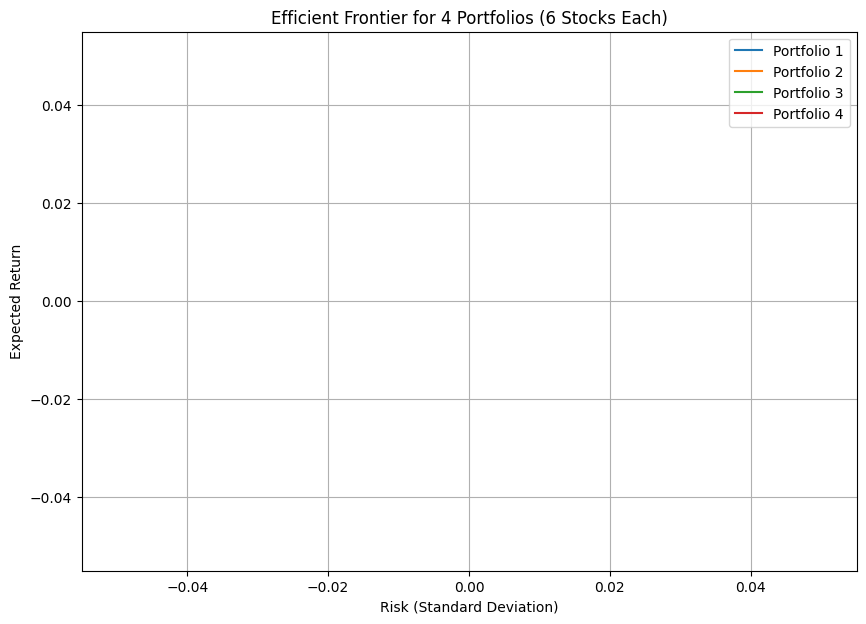

In [ ]:

plt.figure(figsize=(10,7))

plot_efficient_frontier(mean_returns_p1, cov_matrix_p1, "Portfolio 1")
plot_efficient_frontier(mean_returns_p2, cov_matrix_p2, "Portfolio 2")
plot_efficient_frontier(mean_returns_p3, cov_matrix_p3, "Portfolio 3")
plot_efficient_frontier(mean_returns_p4, cov_matrix_p4, "Portfolio 4")

plt.xlabel("Risk (Standard Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier for 4 Portfolios (6 Stocks Each)")
plt.grid(True)
plt.legend()
plt.show()

## change the range to last 20 days...

Aim of the project -- bhevaiour of the diffenrt potfolios during differnt crashes
Means-- that is draw a time seires for these porfolios, check the optimal line where there is mimal risk and the best expected return.

- Lower Left: Low Risk, Low Return

- Upper Right: High Risk, High Return

Portfolio 1 (blue): Seems more conservative (low risk, low return).

Portfolio 2 (orange): A little riskier than Portfolio 1, higher potential returns.

Portfolio 3 (green): This is the most aggressive! It shows very high returns but with higher risks.

Portfolio 4 (red): Quite compressed at the lower end — meaning the stocks might be safer, but returns are smaller.

<ipython-input-156-6c5655a0043d>:8: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


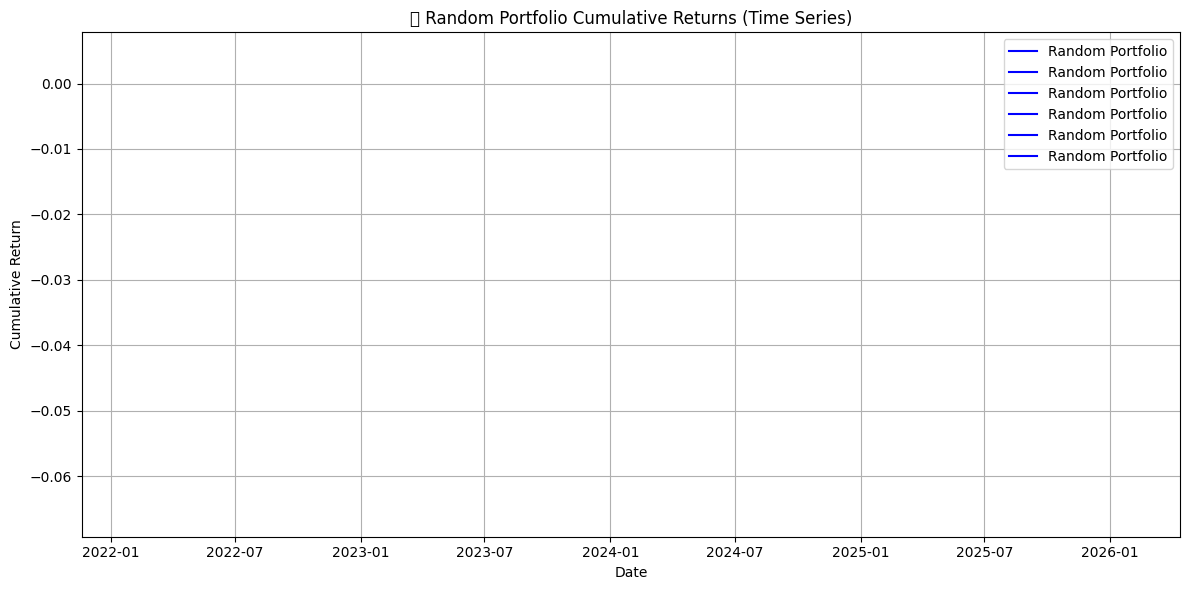

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(returns_p1 , color='blue', label='Random Portfolio')
plt.title('📈 Random Portfolio Cumulative Returns (Time Series)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

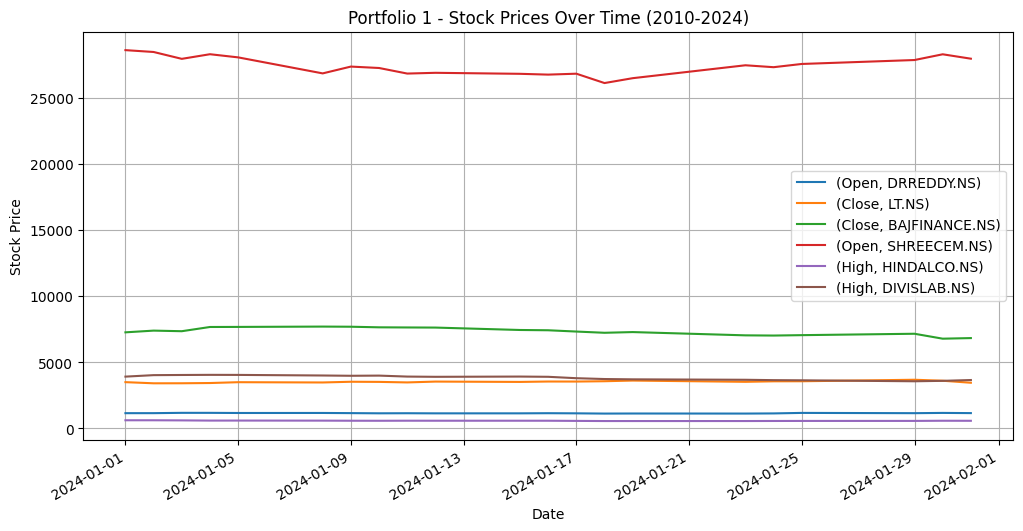

In [ ]:
price_data[portfolio1_stocks].plot(figsize=(12,6))
plt.title("Portfolio 1 - Stock Prices Over Time (2010-2024)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid(True)
plt.legend()
plt.show()



In [ ]:
portfolio1_returns = (monthly_returns[portfolio1_stocks] * (1/6)).sum(axis=1)
portfolio2_returns = (monthly_returns[portfolio2_stocks] * (1/6)).sum(axis=1)
portfolio3_returns = (monthly_returns[portfolio3_stocks] * (1/6)).sum(axis=1)
portfolio4_returns = (monthly_returns[portfolio4_stocks] * (1/6)).sum(axis=1)

# these are the monthly returns of each of the portfolios.

In [ ]:

cumulative_p1 = (1 + portfolio1_returns).cumprod()
cumulative_p2 = (1 + portfolio2_returns).cumprod()
cumulative_p3 = (1 + portfolio3_returns).cumprod()
cumulative_p4 = (1 + portfolio4_returns).cumprod()


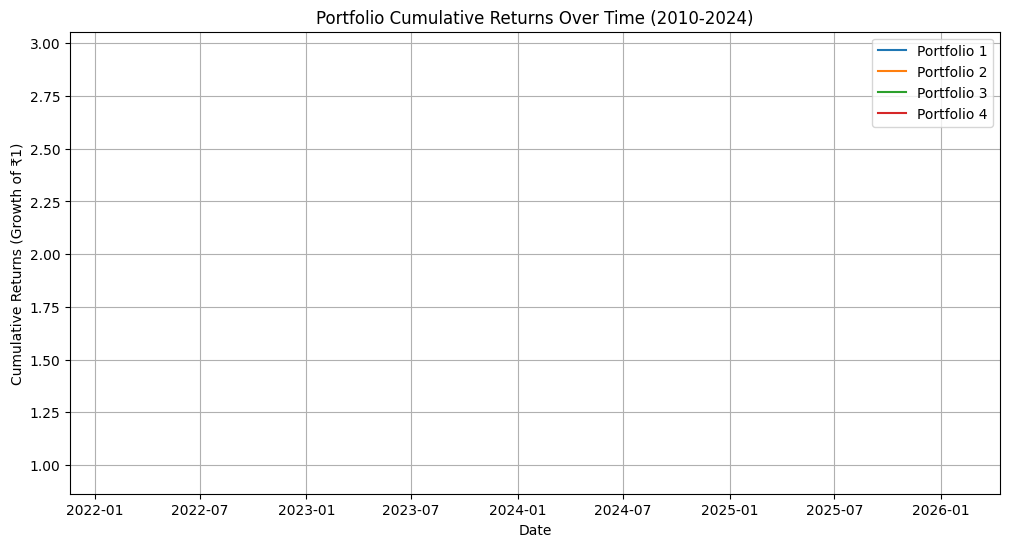

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(cumulative_p1, label="Portfolio 1")
plt.plot(cumulative_p2, label="Portfolio 2")
plt.plot(cumulative_p3, label="Portfolio 3")
plt.plot(cumulative_p4, label="Portfolio 4")
plt.title("Portfolio Cumulative Returns Over Time (2010-2024)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (Growth of ₹1)")
plt.legend()
plt.grid(True)
plt.show()